In [21]:
import sys
import numpy as np
sys.path.insert(0,'..')
from home_location import *

In [22]:
home_locator = HomeLocator('../configs/config_emily.yml')

Loading antennas...


In [28]:
cdr = pd.read_csv('../synthetic_data/cdr.csv')
outgoing = cdr[['caller_id', 'caller_antenna', 'timestamp']]\
    .rename({'caller_id':'name', 'caller_antenna':'antenna_id'}, axis=1)
incoming = cdr[['recipient_id', 'recipient_antenna', 'timestamp']]\
    .rename({'recipient_id':'name', 'recipient_antenna':'antenna_id'}, axis=1)
cdr = pd.concat([outgoing, incoming])
antennas = pd.read_csv('../synthetic_data/antennas.csv')
cdr = cdr.merge(antennas, on='antenna_id', how='inner')

### Modal Tower

In [24]:
homes = home_locator.get_home_locations('count_transactions').rename({'subscriber_id':'name'}, axis=1)

In [25]:
grouped = pd.DataFrame(cdr.groupby('name')['tower_id'].agg(pd.Series.mode))
grouped['tower_id'] = grouped['tower_id'].apply(lambda x:  x if ','.join(x)[1] == ',' else np.nan)
grouped = grouped.dropna()
merged = grouped.merge(homes, on='name')
assert len(merged[merged['tower_id_x'] != merged['tower_id_y']]) == 0

### Tower with Most Unique Days

In [104]:
homes = home_locator.get_home_locations('count_days').rename({'subscriber_id':'name'}, axis=1)

In [105]:
cdr['day'] = cdr['timestamp'].apply(lambda x: x[:10])
grouped = pd.DataFrame(cdr.groupby(['name', 'tower_id'])['timestamp'].nunique())
max_counts = grouped.groupby('name').agg('max')
max_counts = max_counts.to_dict(orient='index')
for key in list(max_counts.keys()):
    max_counts[key] = max_counts[key]['timestamp']
grouped['c'] = [x[0] for x in list(grouped.index)]
grouped['t'] = [x[1] for x in list(grouped.index)]
grouped['max'] = grouped.apply(lambda row: 1 if row['timestamp'] == max_counts[row['c']] else 0, axis=1)
grouped = grouped[grouped['max'] == 1]
included = grouped.groupby('c').agg('count')
included = set(included[included['max'] == 1].index)
grouped = grouped[grouped['c'].isin(included)]\
    .reset_index()\
    .drop(['name', 'tower_id'], axis=1)\
    [['c', 't']].rename({'c':'name', 't':'tower_id'}, axis=1)
assert len(merged[merged['tower_id_x'] != merged['tower_id_y']]) == 0

### Mode of Modes

In [170]:
# This one is nearly impossible to test for with the synthetic data, there are not enough unique modes so 
# it's basically random

### Maps

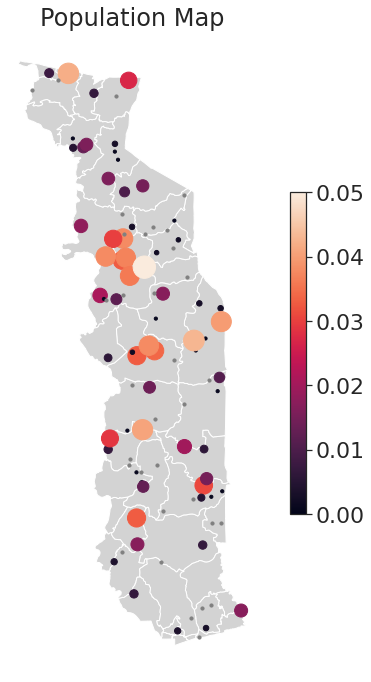

AttributeError: 'HomeLocator' object has no attribute 'poverty_scores'

In [171]:
homes = home_locator.get_home_locations('count_days').rename({'subscriber_id':'name'}, axis=1)
home_locator.map(algo='count_days', kind='population', voronoi=False)
home_locator.map(algo='count_days', kind='poverty', voronoi=True)

Observations with inferred home location: 1000 (1000 unique)
Observations with ground truth home location: 1000 (1000 unique)
Observations with both: 1000 (1000 unique)
Overall accuracy: 0.02


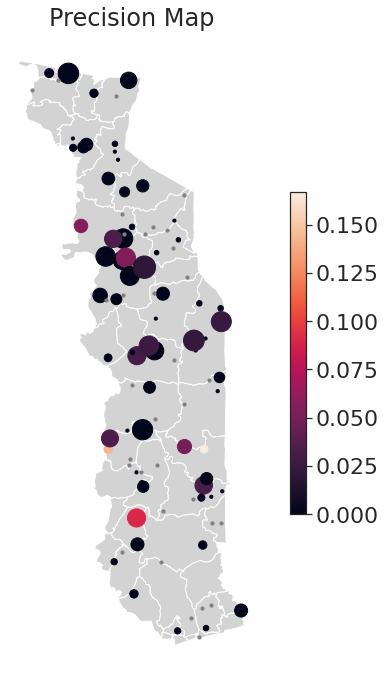

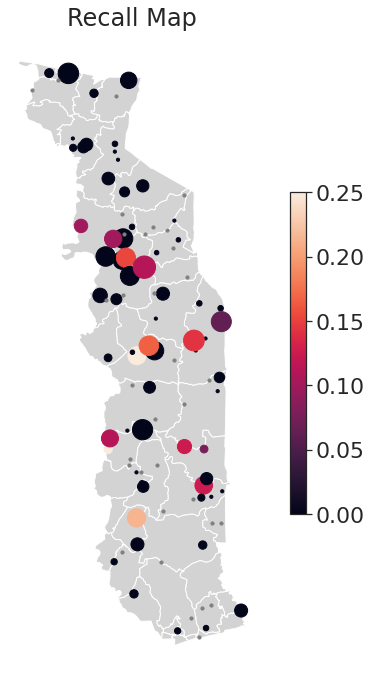

In [6]:
home_locator.accuracy(algo='count_days')
home_locator.map(algo='count_days', kind='precision', voronoi=False)
home_locator.map(algo='count_days', kind='recall', voronoi=False)